In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, LoggingHandler, InputExample, losses, evaluation
from sentence_transformers.losses import SiameseDistanceMetric
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

VOC_NAMES = ["Alpha", "Beta", "Delta", "Gamma", "Omicron"]
LOSS_NAME = "SoftmaxLoss"
POOLING_MODE = "cls"

In [2]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)

encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")

pooler = models.Pooling(encoder.get_word_embedding_dimension(), pooling_mode = POOLING_MODE)


model = SentenceTransformer(modules=[encoder, pooler])

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

# Load Dataset

In [3]:
sequences = []
for voc_name in VOC_NAMES:
    sequences.append(pd.read_csv(f"data/unique_{voc_name}_2k.csv")["sequence"].tolist())

# read a sequence from txt file
with open("data/wildtype.txt", "r") as file:
    wildtype = file.read()

# create dataframe using sequences
df = pd.DataFrame()
df["reference"] = [wildtype for _ in range(10000)]
df["sequence"] = [item for sublist in sequences for item in sublist]
df["label"] = [i for i in range(len(VOC_NAMES)) for _ in range(2000)]

# write to csv
df.to_csv("data/combined_with_wt_10k.csv", index=False)

df

,reference,sequence,label
0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
3,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
4,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
...,...,...,...
9995,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,MFVFLVLLPLVSSQCVNLITRTQSYTNSFTRGVYYPDKVFRSSVXX...,4
9996,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,TQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA...,4
9997,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,TQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHA...,4
9998,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,MFVFLVLLPLVSSQCVNLITRTQSYTNSFTRGVYYPDKVFRSSVLH...,4


In [4]:
examples = []
for i, row in df.iterrows():
    examples.append(InputExample(texts=[row["reference"], row["sequence"]], label=row["label"]))

# shuffle examples with a fixed seed
random.Random(seed).shuffle(examples)

In [5]:
train_examples = examples[:int(len(examples)*0.8)]
dev_examples = examples[int(len(examples)*0.8):int(len(examples)*0.9)]
test_examples = examples[int(len(examples)*0.9):]

In [6]:
batch_size = 200
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
dev_dataloader = DataLoader(dev_examples, shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=batch_size)

In [7]:
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=5)

Softmax loss: #Vectors concatenated: 3


In [8]:
evaluator = evaluation.LabelAccuracyEvaluator(dev_dataloader, softmax_model=train_loss, name="validation")

In [9]:
import os

# Create output directory if needed
output_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}"
checkpoint_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}/checkpoints"
evaluator_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}/eval"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(evaluator_dir):
    os.makedirs(evaluator_dir)

# read loss values from csv:
train_results_file = os.path.join(output_dir, 'eval', 'training_results.csv')
val_results_file = os.path.join(output_dir, 'eval', 'validation_results.csv')

In [10]:
# Check if the file exists before attempting to delete
if os.path.exists(train_results_file):
    try:
        # Attempt to remove the file
        os.remove(train_results_file)
        print(f"File {train_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {train_results_file} does not exist.")

# Check if the file exists before attempting to delete
if os.path.exists(val_results_file):
    try:
        # Attempt to remove the file
        os.remove(val_results_file)
        print(f"File {val_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {val_results_file} does not exist.")

File ./SoftmaxLoss_output_cls/eval/training_results.csv does not exist.
File ./SoftmaxLoss_output_cls/eval/validation_results.csv does not exist.


In [11]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=30,
          optimizer_params= {'lr': 1e-3}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          #evaluation_steps=eval_iter, # run an evalution in every 10% 
          output_path=output_dir,
          save_best_model=True,
          checkpoint_path=checkpoint_dir,
          checkpoint_save_steps=500,
          checkpoint_save_total_limit=2,
          show_progress_bar=True,
          loss_name=LOSS_NAME)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 1.5471   Train Accuracy = 28.5000
Valid Loss = 0.01   Valid Accuracy = 38.50


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 1.2887   Train Accuracy = 50.5000
Valid Loss = 0.01   Valid Accuracy = 56.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 0.7399   Train Accuracy = 77.0000
Valid Loss = 0.00   Valid Accuracy = 72.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 0.4596   Train Accuracy = 85.0000
Valid Loss = 0.00   Valid Accuracy = 85.30


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 0.1856   Train Accuracy = 94.0000
Valid Loss = 0.00   Valid Accuracy = 90.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 0.1092   Train Accuracy = 95.0000
Valid Loss = 0.00   Valid Accuracy = 93.50


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 0.0785   Train Accuracy = 98.5000
Valid Loss = 0.00   Valid Accuracy = 95.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 0.0834   Train Accuracy = 97.0000
Valid Loss = 0.00   Valid Accuracy = 97.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 0.0058   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 96.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 0.0467   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.40


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 10 ---
Train Loss = 0.0372   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 11 ---
Train Loss = 0.0026   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 96.90


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 12 ---
Train Loss = 0.0359   Train Accuracy = 98.5000
Valid Loss = 0.00   Valid Accuracy = 96.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 13 ---
Train Loss = 0.0015   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.50


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 14 ---
Train Loss = 0.0002   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.80


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 15 ---
Train Loss = 0.0145   Train Accuracy = 99.0000
Valid Loss = 0.00   Valid Accuracy = 97.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 16 ---
Train Loss = 0.0004   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 17 ---
Train Loss = 0.0002   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.80


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 18 ---
Train Loss = 0.0111   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 96.90


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 19 ---
Train Loss = 0.0003   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.10


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 20 ---
Train Loss = 0.0101   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 21 ---
Train Loss = 0.0004   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.10


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 22 ---
Train Loss = 0.0137   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.50


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 23 ---
Train Loss = 0.0003   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 24 ---
Train Loss = 0.0001   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 99.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 25 ---
Train Loss = 0.0058   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 98.60


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 26 ---
Train Loss = 0.0006   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 96.10


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 27 ---
Train Loss = 0.0003   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.40


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 28 ---
Train Loss = 0.0013   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 29 ---
Train Loss = 0.0035   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.00


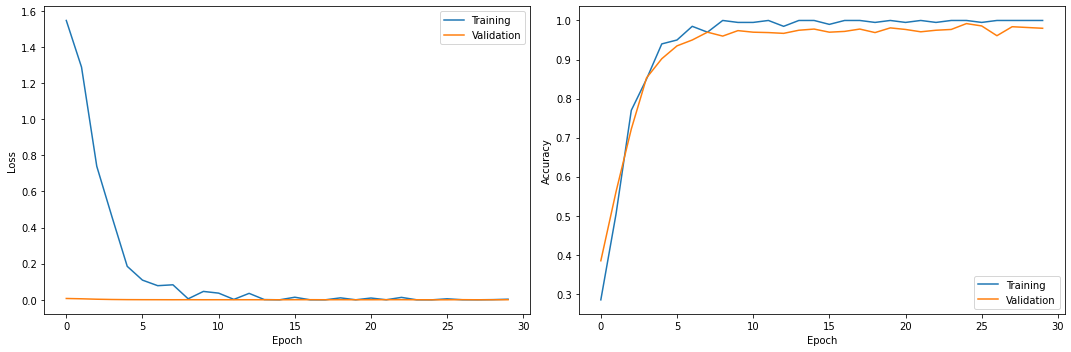

In [12]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# read loss values from csv:
train_results = pd.read_csv(train_results_file)
val_results = pd.read_csv(val_results_file)

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_results["epoch"], train_results["loss"], label="Training")
axs[0].plot(val_results["epoch"], val_results["loss"], label="Validation")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_results["epoch"], train_results["accuracy"], label="Training")
axs[1].plot(val_results["epoch"], val_results["accuracy"], label="Validation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(output_dir, "eval", f'plot_{LOSS_NAME}_{POOLING_MODE}.pdf'))
plt.show()

In [13]:
test_evaluator = evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss, name="test")

# load best model
best_model = SentenceTransformer(output_dir)
best_model.to("cuda")

# print test duration

import time
start_time = time.time()
test_acc = best_model.evaluate(test_evaluator)
duration = time.time() - start_time
print(f"Test duration: {duration} seconds")

# write test accuracy to file
with open(os.path.join(output_dir, "eval", "test_results.txt"), "w") as f:
    f.write(f"Test accuracy: {test_acc}\n")

print(duration * 1000 / len(test_examples), "ms per example")

Valid Loss = 0.00   Valid Accuracy = 98.00
Test duration: 0.17185115814208984 seconds
0.17185115814208984 ms per example
